In [1]:
import math
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.datasets import load_sample_images

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

plt.rcParams["figure.figsize"] = 15, 10

%matplotlib inline

/Users/abulbasar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/Users/abulbasar/anaconda3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/abulbasar/anaconda3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


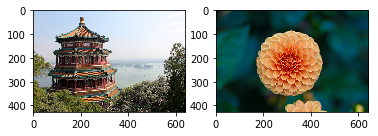

In [2]:
# Load sample images
china, flower = load_sample_images().images
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape
plt.subplot(1, 2, 1)
plt.imshow(china)
plt.subplot(1, 2, 2)
plt.imshow(flower)

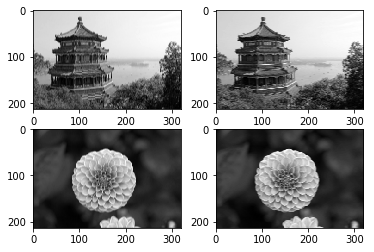

In [3]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

#convolution = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2], padding="SAME")
"""
X is the input mini-batch (a 4D tensor, as explained earlier).

filters is the set of filters to apply (also a 4D tensor, as explained earlier).

strides is a four-element 1D array, where the two central elements are the vertical 
and horizontal strides (sh and sw). The first and last elements must currently be equal to 1. 
They may one day be used to specify a batch stride (to skip some instances) and a channel stride
(to skip some of the previous layer’s feature maps or channels).

padding must be either "VALID" or "SAME":

If set to "VALID", the convolutional layer does not use zero padding, 
and may ignore some rows and columns at the bottom and right of the input image, 
depending on the stride, as shown in Figure 13-7 (for simplicity, only the horizontal 
dimension is shown here, but of course the same logic applies to the vertical dimension).

If set to "SAME", the convolutional layer uses zero padding if necessary. In this case, 
the number of output neurons is equal to the number of input neurons divided by the stride, 
rounded up (in this example, ceil (13 / 5) = 3).
Then zeros are added as evenly as possible around the inputs.
"""

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

for i in range(2):
    for j in range(2):
        plt.subplot(2, 2,i * 2 + j + 1)
        plt.imshow(output[i, :, :, j], cmap="gray") # plot 1st image's 2nd feature map

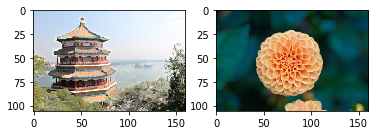

In [4]:
# Create a graph with input X plus a max pooling layer
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,4,4,1], strides=[1,4,4,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.subplot(1, 2, 1)
plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.subplot(1, 2, 2)
plt.imshow(output[1].astype(np.uint8))  # plot the output for the 2nd image

Look that the size of the images have been reduced to half in each direction

In [5]:
base_path = "/data/MNIST"
df_train = pd.read_csv(base_path + "/mnist_train.csv", header = None)
df_test = pd.read_csv(base_path + "/mnist_test.csv", header = None)

X_data_train = df_train.iloc[:, 1:].values / 255 + 0.00001
X_data_test = df_test.iloc[:, 1:].values / 255 + 0.00001
y_data_train = df_train.iloc[:, 0].values 
y_data_test = df_test.iloc[:, 0].values

X_data_train.shape, X_data_test.shape

((60000, 784), (10000, 784))

In [6]:
tf.reset_default_graph()

with tf.Session() as sess:
    y = tf.placeholder(dtype=tf.int32, shape = [None], name="y")
    d = sess.run(tf.one_hot(y, depth=10), feed_dict={y: y_data_train})
df = pd.DataFrame(d)
df["y"] = y_data_train
df.head()

,0,1,2,3,4,5,6,7,8,9,y
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9


In [7]:
class Batchable:
    import math
    import numpy as np
    
    def shuffle(self):
        X = self.X
        y = self.y
        idx = np.arange(X.shape[0])
        np.random.shuffle(idx)
        self.X = X[idx, :]
        self.y = y[idx]
        return
    
    def __init__(self, X, y, batch_size = 128, seed = 1):
        np.random.seed(seed)
        self.X = X
        self.y = y
        self.shuffle()
        self.start = 0
        self.batch_size = batch_size
        self.num_batches = math.ceil(X.shape[0] / batch_size)
    
    def next(self):
        start = self.start
        end = self.start + self.batch_size
        end = min(self.X.shape[0], end)
        self.start = end % self.X.shape[0]
        return self.X[start: end, :], self.y[start: end]
    
def show(scores, ax = None):
    df = pd.DataFrame.from_dict(scores)
    if ax is None:
        _, ax = plt.subplots()
    df.plot.line(alpha = 0.4, ax = ax)
    df.rolling(100, min_periods=1).mean().plot.line(ax = ax) 

{'iteration': 0, 'training': 0.12361667, 'testing:': 0.1211}
{'iteration': 500, 'training': 0.62021667, 'testing:': 0.6275}
{'iteration': 1000, 'training': 0.75865, 'testing:': 0.7665}
{'iteration': 1500, 'training': 0.81121665, 'testing:': 0.81690001}
{'iteration': 2000, 'training': 0.83798331, 'testing:': 0.84079999}
{'iteration': 2500, 'training': 0.8556, 'testing:': 0.85960001}
{'iteration': 3000, 'training': 0.86778331, 'testing:': 0.87059999}
{'iteration': 3500, 'training': 0.87578332, 'testing:': 0.87709999}
{'iteration': 4000, 'training': 0.88223332, 'testing:': 0.88260001}
{'iteration': 4500, 'training': 0.88613331, 'testing:': 0.88569999}
{'iteration': 5000, 'training': 0.89088333, 'testing:': 0.88940001}
{'iteration': 5500, 'training': 0.89469999, 'testing:': 0.89300001}
{'iteration': 6000, 'training': 0.89738333, 'testing:': 0.89660001}
{'iteration': 6500, 'training': 0.89950001, 'testing:': 0.89709997}
{'iteration': 7000, 'training': 0.9018833, 'testing:': 0.89749998}
{'it

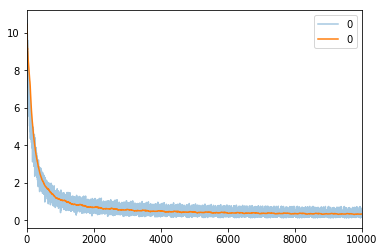

In [8]:
tf.reset_default_graph()

iterations = 10000
mini_batch_size = 128
n_y = 10
n_x = 784
n_h = 300


X = tf.placeholder(tf.float32, [None, n_x])
y = tf.placeholder(tf.int32, [None])

y_oh = tf.one_hot(y, depth = n_y)

W = tf.Variable(tf.truncated_normal(shape=[n_x, n_y], seed=1))
b = tf.zeros(shape=[n_y])

y_pred = tf.matmul(X, W) + b

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels= y_oh))

gd_step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
#gd_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

scores =[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batchable = Batchable(X_data_train, y_data_train, mini_batch_size)
    for i in range(iterations):
        batch_x, batch_y = batchable.next()
        _, cost_ = sess.run([gd_step, cost], feed_dict={X: batch_x, y: batch_y})
        scores.append(cost_)
        if i % 500 == 0 or i == iterations - 1:
            accuracy_train = sess.run(accuracy, feed_dict={X: X_data_train, y: y_data_train})
            accuracy_test = sess.run(accuracy, feed_dict={X: X_data_test, y: y_data_test})
            d = {"iteration": i,"training": accuracy_train, "testing:":  accuracy_test}
            print(d)
            
show(scores)

{'iteration': 0, 'training': 0.092216663, 'testing:': 0.0973}
{'iteration': 500, 'training': 0.85761666, 'testing:': 0.85860002}
{'iteration': 1000, 'training': 0.90195, 'testing:': 0.89679998}
{'iteration': 1500, 'training': 0.92206669, 'testing:': 0.91030002}
{'iteration': 2000, 'training': 0.93383336, 'testing:': 0.92140001}
{'iteration': 2500, 'training': 0.94318336, 'testing:': 0.92659998}
{'iteration': 3000, 'training': 0.94901669, 'testing:': 0.9289}
{'iteration': 3500, 'training': 0.95695001, 'testing:': 0.9339}
{'iteration': 4000, 'training': 0.96263331, 'testing:': 0.93739998}
{'iteration': 4500, 'training': 0.9634167, 'testing:': 0.93669999}
{'iteration': 5000, 'training': 0.96713334, 'testing:': 0.93879998}
{'iteration': 5500, 'training': 0.97250003, 'testing:': 0.94169998}
{'iteration': 6000, 'training': 0.97589999, 'testing:': 0.94559997}
{'iteration': 6500, 'training': 0.97750002, 'testing:': 0.94459999}
{'iteration': 7000, 'training': 0.98091668, 'testing:': 0.94389999}

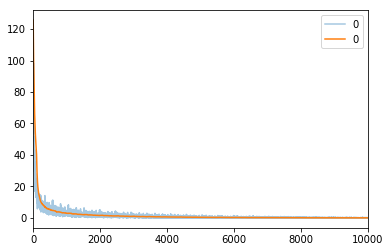

In [9]:
tf.reset_default_graph()

iterations = 10000
mini_batch_size = 128
n_y = 10
n_x = 784
n_h = 300


X = tf.placeholder(tf.float32, [None, n_x])
y = tf.placeholder(tf.int32, [None])

W1 = tf.Variable(tf.truncated_normal(shape=[n_x, n_h], seed=1))
b1 = tf.zeros(shape=[n_h])

y_oh = tf.one_hot(y, depth = n_y)

A1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.truncated_normal(shape=[n_h, n_y], seed=1))
b2 = tf.zeros(shape=[n_y])

y_pred = tf.matmul(A1, W2) + b2

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels= y_oh))

#gd_step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
gd_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

correct_mask = tf.equal(tf.argmax(y_pred, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))

scores =[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batchable = Batchable(X_data_train, y_data_train, mini_batch_size)
    for i in range(iterations):
        batch_x, batch_y = batchable.next()
        _, cost_ = sess.run([gd_step, cost], feed_dict={X: batch_x, y: batch_y})
        scores.append(cost_)
        if i % 500 == 0 or i == iterations - 1:
            accuracy_train = sess.run(accuracy, feed_dict={X: X_data_train, y: y_data_train})
            accuracy_test = sess.run(accuracy, feed_dict={X: X_data_test, y: y_data_test})
            d = {"iteration": i,"training": accuracy_train, "testing:":  accuracy_test}
            print(d)
            
show(scores)

{'iteration': 0, 'train accuracy': 0.0859375, 'test accuracy': 0.0691}
{'iteration': 10, 'train accuracy': 0.2109375, 'test accuracy': 0.2775}
{'iteration': 20, 'train accuracy': 0.3203125, 'test accuracy': 0.56120002}
{'iteration': 30, 'train accuracy': 0.3515625, 'test accuracy': 0.64590001}
{'iteration': 40, 'train accuracy': 0.6171875, 'test accuracy': 0.741}
{'iteration': 50, 'train accuracy': 0.609375, 'test accuracy': 0.8028}
{'iteration': 60, 'train accuracy': 0.6640625, 'test accuracy': 0.84719998}
{'iteration': 70, 'train accuracy': 0.6875, 'test accuracy': 0.86360002}
{'iteration': 80, 'train accuracy': 0.7421875, 'test accuracy': 0.88169998}
{'iteration': 90, 'train accuracy': 0.7421875, 'test accuracy': 0.88940001}
{'iteration': 100, 'train accuracy': 0.7421875, 'test accuracy': 0.89590001}
{'iteration': 110, 'train accuracy': 0.7578125, 'test accuracy': 0.90319997}
{'iteration': 120, 'train accuracy': 0.84375, 'test accuracy': 0.90420002}
{'iteration': 130, 'train accurac

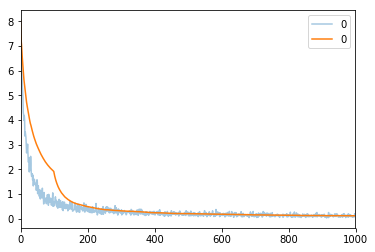

In [10]:
tf.reset_default_graph()

n_x, n_y = 784, 10
iterations = 1000

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)


def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b


X = tf.placeholder(tf.float32, shape=[None, n_x], name = "X")
y = tf.placeholder(tf.int32, shape=[None], name = "y")
y_oh = tf.one_hot(y, depth = n_y)

x_image = tf.reshape(X, [-1, 28, 28, 1])
conv1 = conv_layer(x_image, shape=[5, 5, 1, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32, name="keep_prob")
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels= y_oh))
optimization = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.cast(y, tf.int64))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

accuracy = accuracy

batchable = Batchable(X_data_train, y_data_train)
scores = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(iterations):
        batch_x, batch_y = batchable.next()
        _, train_accuracy, cost = sess.run([optimization, accuracy, cross_entropy], 
                                         feed_dict={X: batch_x, y: batch_y, keep_prob: 0.8})
        scores.append(cost)
        if i % 10 == 0 or i == iterations - 1:
            test_accuracy = sess.run(accuracy, feed_dict={X: X_data_test, y: y_data_test, keep_prob: 1.0})
            print({"iteration": i, "train accuracy": train_accuracy, "test accuracy": test_accuracy})
                
show(scores)    

